In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# current_dir = os.getcwd()
# parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
current_dir = "/home/kruu/git_folder/porosity_reconstruction/notebooks"
parent_dir = "/home/kruu/git_folder/porosity_reconstruction/"
sys.path.append(parent_dir)

from utils.data_processing import load_pore_matrices
from models.vae import VAE
from utils.poreDataset import PoreDataset

****
# Problem description
****

Probleme physique:
- Input: grille dans le carré unité avec 0 si pas de pores et 1 si des pores
- Output: density factor qui est le ratio du volume des pores / volume du cube

Problème inverse:
- Input: Density factor
- Output: grille avec 0 ou 1 i.e. distribution jointe de bernoulli

Goal: Il faut apprendre la distribution de la grille (joint bernoulli distributions) conditionnellement au density factor.

Challenges:
- La grille est sparse, donc le modèle a tendence à vouloir apprendre la matrice remplie de 0 ce qui a de grande chances de minimiser la loss. Idée: faire une weighted loss où on focus sur tous les 1 + quelques 0 tirés aléatoirement (negative sampling)
- Les 1 adjacents sont probablement un même pore mais plus gros. Est-il important de calculer ces gros pores ainsi que leur volume, ou alors juste l'agencement de 1 suffit?

Idée principale:
- GAN: Espace latent (inputs), serait tiré dans la distribution des density factors + outputs = matries reconstruites
- Autre idée: Faire un U-net ou VAE où la distribution à priori = la distribution du density factor (1D). L'encoder apprendrait le problème physiaue, alors que le décoder le problème inverse. 
- Comme l'input est une matrice en 3D, et qu'on cherche les patterns de cette matrice, on aurait envie d'utiliser des CNN dans l'encoder et le decoder. 

****
# Load data
****

In [2]:
data_folder = os.path.join(parent_dir, "data")
npy_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(".npy")]

data_dict, grid_dict, densities_dict = load_pore_matrices(npy_files)


****
# Visualisation
****

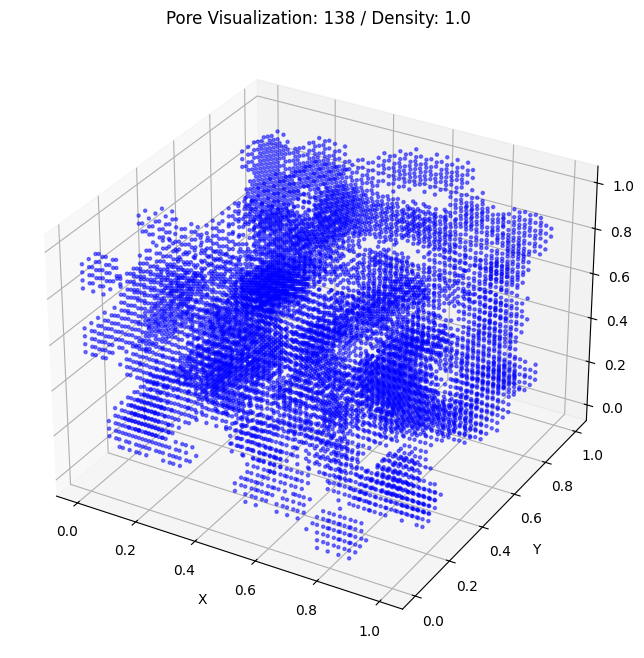

In [3]:
index = "138"
data_to_plot = data_dict[index]

# Extract only the points inside pores (occupancy == 1)
pores = data_to_plot[data_to_plot[:, 3] == 1]

# Extract x, y, z coordinates
x, y, z = pores[:, 0], pores[:, 1], pores[:, 2]

# Plot 3D scatter of pores
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='blue', marker='o', alpha=0.5, s=5)  # Blue dots for pores

# Labels and title
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title(f"Pore Visualization: {index} / Density: {densities_dict[index]}")

# Show the plot
plt.show()

In [9]:
tests1 = []
for keys, item in densities_dict.items():
    if 0.5<item<0.6:
        tests1.append(keys)

tests1

['004',
 '007',
 '043',
 '047',
 '066',
 '068',
 '071',
 '079',
 '094',
 '106',
 '112',
 '121',
 '129',
 '132',
 '140',
 '150',
 '165',
 '168',
 '173',
 '185',
 '195',
 '207',
 '221',
 '242',
 '254',
 '260',
 '266',
 '267',
 '269',
 '278',
 '283',
 '293',
 '310',
 '315',
 '320',
 '323',
 '332',
 '336',
 '339',
 '342',
 '354',
 '382',
 '391',
 '411',
 '415',
 '431',
 '433',
 '441',
 '442',
 '446',
 '456',
 '464',
 '487',
 '495']

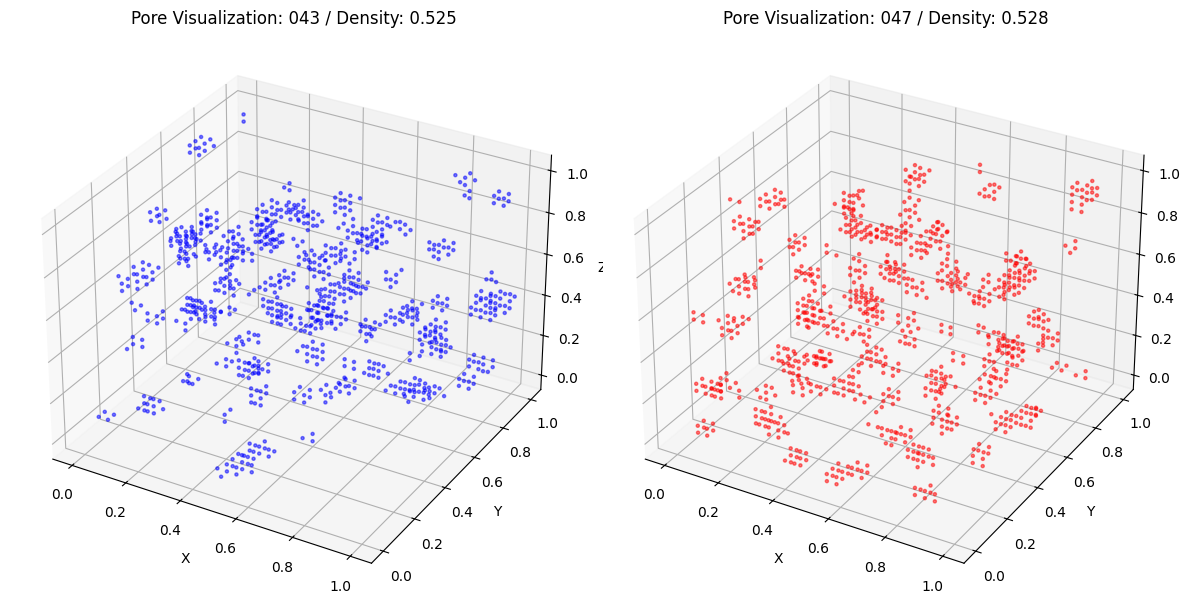

In [15]:
# Define indices for the two grids to compare
index1 = "043"
index2 = "047"

# Extract data for both grids
data1 = data_dict[index1]
data2 = data_dict[index2]

# Extract only the points inside pores (occupancy == 1)
pores1 = data1[data1[:, 3] == 1]
pores2 = data2[data2[:, 3] == 1]

# Extract x, y, z coordinates
x1, y1, z1 = pores1[:, 0], pores1[:, 1], pores1[:, 2]
x2, y2, z2 = pores2[:, 0], pores2[:, 1], pores2[:, 2]

# Create side-by-side 3D scatter plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})

# Plot first grid
axes[0].scatter(x1, y1, z1, c='blue', marker='o', alpha=0.5, s=5)
axes[0].set_title(f"Pore Visualization: {index1} / Density: {densities_dict[index1]}")
axes[0].set_xlabel("X")
axes[0].set_ylabel("Y")
axes[0].set_zlabel("Z")

# Plot second grid
axes[1].scatter(x2, y2, z2, c='red', marker='o', alpha=0.5, s=5)
axes[1].set_title(f"Pore Visualization: {index2} / Density: {densities_dict[index2]}")
axes[1].set_xlabel("X")
axes[1].set_ylabel("Y")
axes[1].set_zlabel("Z")

# Adjust layout and show plot
plt.tight_layout()
plt.show()


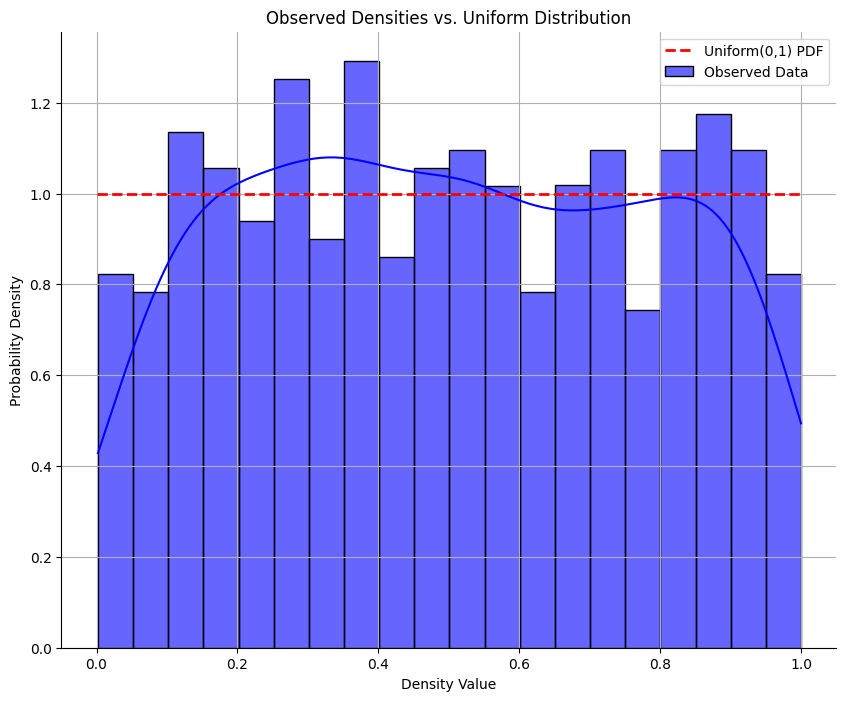

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform

# Convert dictionary values to a NumPy array
density_values = np.array(list(densities_dict.values()))

# Generate the ideal uniform distribution PDF
x_range = np.linspace(0, 1, 100)
uniform_pdf = uniform.pdf(x_range, loc=0, scale=1)

# histogram of density values
plt.figure(figsize=(10, 8))
sns.histplot(density_values, bins=20, kde=True, stat="density", label="Observed Data", color="blue", alpha=0.6)

# uniform distribution
plt.plot(x_range, uniform_pdf, color="red", linestyle="dashed", linewidth=2, label="Uniform(0,1) PDF")


plt.xlabel("Density Value")
plt.ylabel("Probability Density")
plt.title("Observed Densities vs. Uniform Distribution")
plt.legend()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.grid(True)
plt.show()

In [9]:
from scipy.stats import ks_1samp

# Perform KS test to verify if the distribution of densities is uniform
ks_stat, p_value = ks_1samp(density_values, uniform(loc=0, scale=1).cdf)
print(f"P-value: {p_value:.4f}")

if p_value > 0.05:
    print("The data does not significantly differ from a uniform distribution (Fail to reject H0).")
else:
    print("The data significantly differs from a uniform distribution (Reject H0).")


P-value: 0.8784
The data does not significantly differ from a uniform distribution (Fail to reject H0).


****
# Fitting Density VS number of ones
****

Fitted Power-Law Function: Density = 0.0882 * (Number of Ones)^0.2632


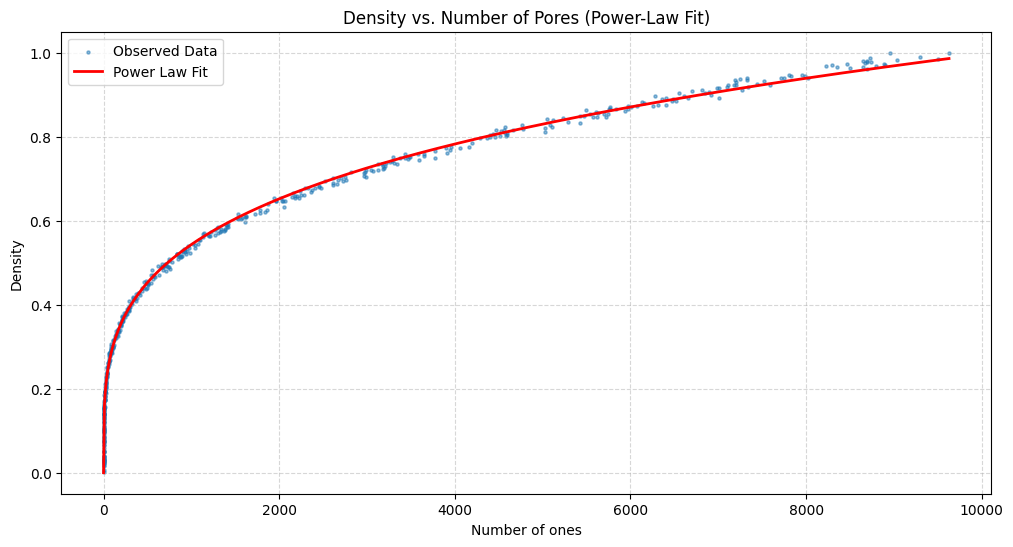

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

ones = []
for _, values in grid_dict.items():
    ones.append(values.sum())
ones = np.array(ones)
density_values = np.array(density_values)

# Define a power-law function
def power_law(x, a, b):
    return a * x**b

# Fit the model using curve_fit
params, covariance = curve_fit(power_law, ones, density_values, maxfev=10000)
a_opt, b_opt = params
print(f"Fitted Power-Law Function: (Density) = {a_opt:.4f} * (Number of Ones)^{b_opt:.4f}")

# Generate fitted values
x_range = np.linspace(min(ones), max(ones), 1000)
y_fit = power_law(x_range, a_opt, b_opt)

# Plot Data
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(ones, density_values, marker='o', alpha=0.5, s=5, label="Observed Data")
ax.plot(x_range, y_fit, color="red", linewidth=2, label="Power Law Fit")

# Labels and Grid
ax.set_xlabel("Number of ones")
ax.set_ylabel("Density")
ax.set_title("Density vs. Number of Pores (Power-Law Fit)")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

# Show plot
plt.show()

In [91]:
from sklearn.metrics import r2_score
y_pred = power_law(ones, a_opt, b_opt)
r2 = r2_score(density_values, y_pred)
print(f"R² Score: {r2:.4f}")

R² Score: 0.9963


****
# CNN Model
****

In [ ]:
import os
import sys
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(parent_dir)

import torch
import pytorch_lightning as pl

from utils.poreDataset import PoreDataset
from models.cnn import CNNGenerator
from torch.utils.data import DataLoader, random_split
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

data_folder = os.path.join(parent_dir, "data")
npy_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(".npy")]

dataset = PoreDataset(npy_files)
total_size = len(dataset)
val_size = int(total_size * 0.1)
train_size = total_size - val_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False)

# Train model
model = CNNGenerator(lr = 0.001, alpha=0, beta=0)
trainer = pl.Trainer(max_epochs=200, 
                     accelerator="gpu" if torch.cuda.is_available() else "cpu",
                     log_every_n_steps=10,
                     gradient_clip_val=1.0,
                     callbacks=[
            EarlyStopping(monitor="val_loss", patience=5, mode="min"),
            ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1, filename="best_reconstructor")
                     ]
)

trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\kruu\git_folder\porosity_reconstruction\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
c:\Users\kruu\git_folder\porosity_reconstruction\.venv\Lib\site-packages\pytorch_lightning\core\optimizer.py:378: Found unsupported keys in the optimizer configuration: {'gradient_clip_val'}

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | fc      | Sequential | 8.9 M  | train
1 | deco

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\kruu\git_folder\porosity_reconstruction\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


c:\Users\kruu\git_folder\porosity_reconstruction\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 1:  49%|████▉     | 57/116 [00:19<00:19,  2.96it/s, v_num=15, train_loss_step=1.6e+8, val_loss=1.46e+9, train_loss_epoch=1.88e+8]  

: 

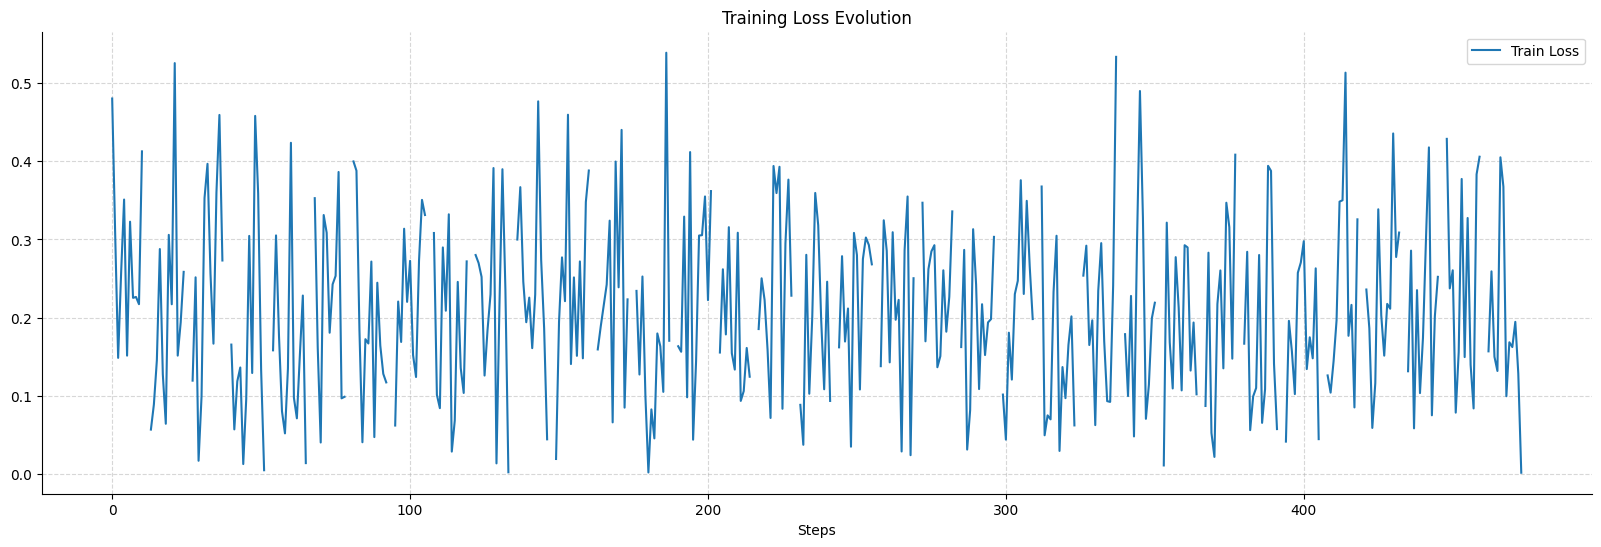

In [3]:
import pandas as pd
metrics = pd.read_csv(os.path.join(current_dir, "lightning_logs", "version_10", "metrics.csv"))
import matplotlib.pyplot as plt

# Plot the original time series
plt.figure(figsize=(20, 6))
plt.plot(metrics["train_loss_step"], label='Train Loss')
plt.title("Training Loss Evolution")
plt.xlabel('Steps')
plt.ylabel('')
plt.grid(True, alpha = 0.5, linestyle = "--")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.ylim((0,100))
plt.legend()
plt.show()

In [14]:
model.eval()
grid, density = dataset.__getitem__(0)
reco_grid = model(density.unsqueeze(0))

k = reco_grid.sum()
reco_grid.argsort()

tensor([[[[[12, 13, 11,  ...,  1,  0, 29],
           [12, 13, 11,  ...,  3,  4,  2],
           [29, 12,  0,  ...,  2,  3,  4],
           ...,
           [29,  0, 14,  ..., 23, 22, 21],
           [29, 14, 13,  ..., 23, 22, 21],
           [13, 14, 12,  ..., 22, 21,  0]],

          [[13, 14, 12,  ...,  3,  4, 29],
           [29,  0, 28,  ...,  5,  3,  4],
           [29,  0, 28,  ...,  5,  3,  4],
           ...,
           [ 0, 29, 28,  ..., 24, 22, 23],
           [ 0, 29, 14,  ..., 24, 22, 23],
           [ 0, 14, 13,  ..., 21, 23, 22]],

          [[28, 27, 14,  ...,  3,  5,  4],
           [29,  0, 28,  ...,  3,  5,  4],
           [29,  0, 28,  ...,  6,  5,  4],
           ...,
           [ 0, 29, 28,  ..., 24, 22, 23],
           [ 0, 29, 28,  ..., 24, 22, 23],
           [ 0, 14, 13,  ..., 24, 22, 23]],

          ...,

          [[15, 16, 14,  ..., 23, 25, 24],
           [29,  0, 15,  ..., 23, 24, 25],
           [ 0, 29, 15,  ..., 23, 24, 25],
           ...,
           

In [9]:
grid

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

tensor(-1.0568, grad_fn=<MaxBackward1>)

****
# VAE Model
****

In [1]:
import os
import sys
# current_dir = os.getcwd()
# parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
# sys.path.append(parent_dir)
current_dir = "/home/kruu/git_folder/porosity_reconstruction/notebooks"
parent_dir = "/home/kruu/git_folder/porosity_reconstruction/"
sys.path.append(parent_dir)

import torch
import pytorch_lightning as pl

from models.vae import PoreDataset, VAE
from torch.utils.data import DataLoader, random_split
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

data_folder = os.path.join(parent_dir, "data")
npy_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(".npy")]

dataset = PoreDataset(npy_files)
total_size = len(dataset)
val_size = int(total_size * 0.1)
train_size = total_size - val_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)

# Train model
# Alpha and gamma are really important parameters for the model
# Try to do a wandb sweep architecture on the cluster
model = VAE(latent_dim=256, lr=1e-5, beta = 0.1, alpha=1, gamma=1)
trainer = pl.Trainer(max_epochs=50, 
                     accelerator="gpu" if torch.cuda.is_available() else "cpu",
                     log_every_n_steps=10,
                     callbacks=[
            # EarlyStopping(monitor="val_loss", patience=5, mode="min"),
            ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1, filename="best_reconstructor")
                     ],
                     default_root_dir=parent_dir,
)

trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kruu/.conda/envs/aware/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/home/kruu/.conda/envs/aware/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:378: Found unsupported keys in the optimizer configuration: {'gradient_clip_val'}

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | encoder       | Sequential | 1.2 M  | train
1 | fc_mu         | 

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/kruu/.conda/envs/aware/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=51` in the `DataLoader` to improve performance.


/home/kruu/.conda/envs/aware/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=51` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 29/29 [00:13<00:00,  2.14it/s, v_num=4, train_loss_step=0.172, val_loss=0.167, train_loss_epoch=0.174]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 29/29 [00:13<00:00,  2.14it/s, v_num=4, train_loss_step=0.172, val_loss=0.167, train_loss_epoch=0.174]


****
# Results
****

In [7]:
import pandas as pd
import torch

metrics = pd.read_csv(os.path.join(parent_dir, "lightning_logs", "version_4", "metrics.csv"))

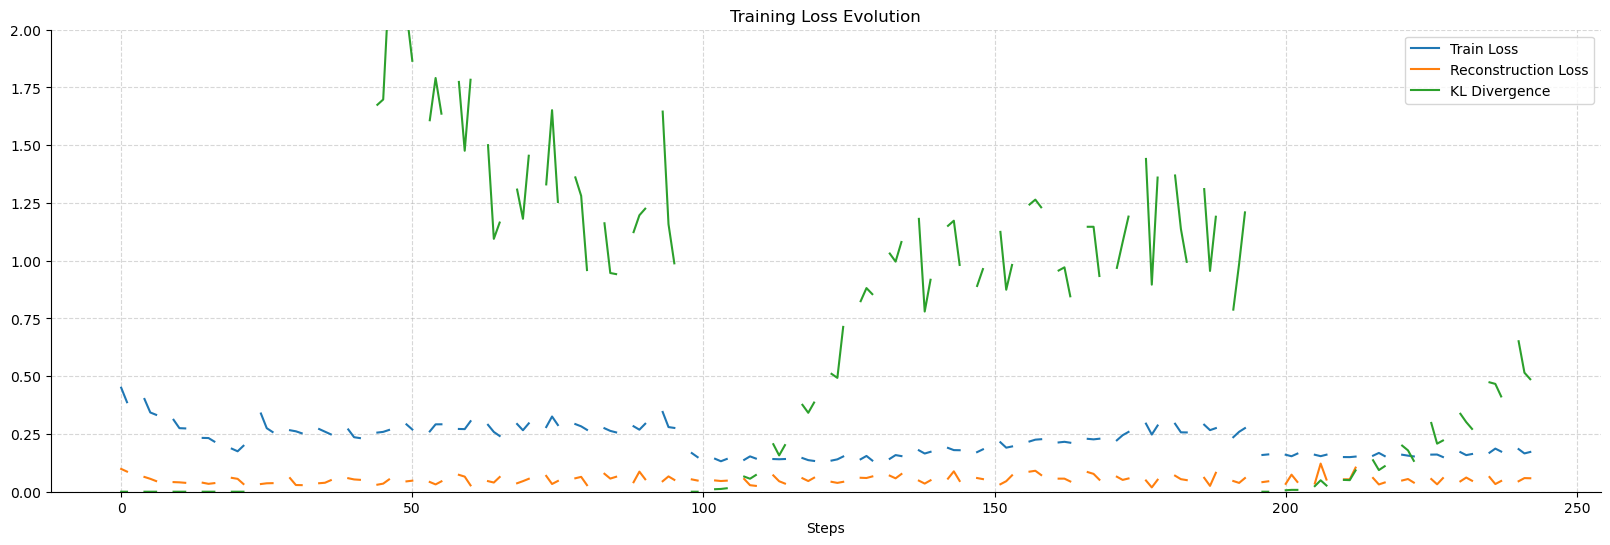

In [5]:
import matplotlib.pyplot as plt

# Plot the original time series
plt.figure(figsize=(20, 6))
plt.plot(metrics["train_loss_step"], label='Train Loss')
plt.plot(metrics["reconstruction_loss"], label='Reconstruction Loss')
plt.plot(metrics["kl_divergence"], label='KL Divergence')
plt.title("Training Loss Evolution")
plt.xlabel('Steps')
plt.ylabel('')
plt.grid(True, alpha = 0.5, linestyle = "--")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.ylim((0,2))
plt.legend()
plt.show()

In [8]:
ckpt_path = os.path.join(parent_dir,"lightning_logs", "version_4", "checkpoints", "best_reconstructor.ckpt")
model_load = VAE(latent_dim=256, lr=1e-5, beta = 0.1, alpha=1, gamma=1)
model_load.load_state_dict(torch.load(ckpt_path)["state_dict"])
model_load.eval()

VAE(
  (encoder): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (7): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (10): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=16384, out_features=256, bias=True)
  (fc_logvar): Linear(in_features=16384, out_features=256, bias=True)
  (decoder_input): Linear

In [9]:
from utils.visualisation import plot_pore_reconstruction

index = 9
grid_truth, d_truth = dataset.__getitem__(index)
grid_reco, mu, logvar = model_load.forward(grid_truth.unsqueeze(0), d_truth.unsqueeze(0))

plot_pore_reconstruction(grid_truth.squeeze(), grid_reco.squeeze(), index, f"reco {index}", d_truth)

NameError: name 'dataset' is not defined

In [ ]:
# TODO: Visualize latent space
from torch.utils.data import DataLoader

# Load all data at once
data_latent_space = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

# Fetch all data in one go
for grids, densities in data_latent_space:
    all_grids = grids
    all_densities = densities 
    break

# Perform inference
model.eval()
with torch.no_grad():
    recos, mus, logvars = model_load(all_grids, all_densities)  # Forward pass

In [ ]:
print((mus[0] - mus[1]).max(), (logvars[0] - logvars[1]).max())
#Looks like there is not posterior collapse

tensor(1.7244) tensor(0.9353)


The model learns probabilities that are extremely lows, and in the end we only have zeros. We have to modify the loss to be able to identify the ones more accurately. Moreover, we can fit a model between the density and the number of ones, so that the threshold is not arbitrarily 1 but the k greatest probabilities where k is given for a certain density. 

In [ ]:
from utils.visualisation import generate_pore_grid

generate_pore_grid(model_load, 0.3, random_sample=True)
